In [1]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, CuDNNLSTM
import numpy as np
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
%%bash
echo wget http://www.manythings.org/anki/ben-eng.zip
echo unzip ben-eng.zip

wget http://www.manythings.org/anki/ben-eng.zip
unzip ben-eng.zip


In [0]:
batch_size = 64
epochs = 20
latent_dim = 256
num_samples = 10000
data_path = "ben.txt"

In [0]:
# vectorize the data
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

with open(data_path) as f:
  lines = f.readlines()
  
for line in lines[:min(num_samples, len(lines) - 1)]:
  input_text, target_text = line.split("\t")
  
  # we use tab for the start sequencer character and "\n" as the end sequence character
  target_text = "\t" + target_text + "\n"
  input_texts.append(input_text)
  target_texts.append(target_text)
  
  for char in input_text:
    if char not in input_characters:
      input_characters.add(char)
  for char in target_text:
    if char not in target_characters:
      target_characters.add(char)

In [5]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples", len(input_texts))
print("Number of unique input tokens", num_encoder_tokens)
print("Number of unique output tokens", num_decoder_tokens)
print("Maximum sequence length of inputs", max_encoder_seq_length)
print("Maximum sequence length of outputs", max_decoder_seq_length)

Number of samples 4399
Number of unique input tokens 71
Number of unique output tokens 93
Maximum sequence length of inputs 94
Maximum sequence length of outputs 87


In [0]:
input_token_index = dict([(char, i) for i, char in enumerate( input_characters )])
target_token_index = dict([(char, i) for i, char in enumerate( target_characters )])

In [0]:
encoder_input_data = np.zeros((len( input_texts ), max_encoder_seq_length, num_encoder_tokens), dtype="float32")
decoder_input_data = np.zeros((len( input_texts ), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
decoder_target_data = np.zeros((len( target_texts ), max_decoder_seq_length, num_decoder_tokens), dtype="float32")

In [0]:
for i, (input_text, target_text) in enumerate(zip( input_texts, target_texts )):
  for t, char in enumerate( input_text ):
    encoder_input_data[i, t, input_token_index[char] ] = 1.
  for t, char in enumerate( target_text ):
    # decoder target data is ahead of decoder input data by 1 timestep.
    decoder_input_data[i, t, target_token_index[char] ] = 1.
    if t>0:
      # decoder_target_data will be ahead by one timestep
      # and will not include the start character.
      decoder_target_data[i, t-1, target_token_index[char] ] = 1.

In [0]:
# define an input sequence and process it
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = CuDNNLSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# we discard the encoder_outputs and only keep the states
encoder_states = [state_h, state_c]

In [0]:
# set up the decoder with input states as the initial state
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = CuDNNLSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm( decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense( num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

In [0]:
# Define the model that will turn
# encoder_input_data and decoder_input_data into decoder_target_data
model = Model([ encoder_inputs, decoder_inputs ], decoder_outputs)

In [12]:
# run training
model.compile( optimizer="rmsprop", loss="categorical_crossentropy" )
history = model.fit([ encoder_input_data, decoder_input_data ], decoder_target_data,
          batch_size=batch_size, epochs=epochs, validation_split=0.2)

Train on 3519 samples, validate on 880 samples
Epoch 1/20
3519/3519 [==============================] - 6s 2ms/step - loss: 0.7900 - val_loss: 1.3917
Epoch 2/20
3519/3519 [==============================] - 4s 1ms/step - loss: 0.7184 - val_loss: 1.3128
Epoch 3/20
3519/3519 [==============================] - 4s 1ms/step - loss: 0.6428 - val_loss: 1.1593
Epoch 4/20
3519/3519 [==============================] - 4s 1ms/step - loss: 0.5764 - val_loss: 1.1107
Epoch 5/20
3519/3519 [==============================] - 4s 1ms/step - loss: 0.5316 - val_loss: 1.0566
Epoch 6/20
3519/3519 [==============================] - 4s 1ms/step - loss: 0.5006 - val_loss: 1.0024
Epoch 7/20
3519/3519 [==============================] - 4s 1ms/step - loss: 0.4782 - val_loss: 0.9962
Epoch 8/20
3519/3519 [==============================] - 4s 1ms/step - loss: 0.4607 - val_loss: 0.9869
Epoch 9/20
3519/3519 [==============================] - 4s 1ms/step - loss: 0.4471 - val_loss: 0.9371
Epoch 10/20
3519/3519 [============

In [13]:
# save model
model.save("s2s.h5")

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer cu_dnnlstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [0]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

In [0]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [0]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [18]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: আমি একটা ভালো লাগে না।

-
Input sentence: Go.
Decoded sentence: আমি একটা ভালো লাগে না।

-
Input sentence: Go.
Decoded sentence: আমি একটা ভালো লাগে না।

-
Input sentence: Run!
Decoded sentence: আমি একটা ভালো লাগে না।

-
Input sentence: Run!
Decoded sentence: আমি একটা ভালো লাগে না।

-
Input sentence: Who?
Decoded sentence: আমরা কি বারি তারি না।

-
Input sentence: Fire!
Decoded sentence: আমি একটা ভালো লাগে না।

-
Input sentence: Help!
Decoded sentence: আমরা কি বারি তারি না।

-
Input sentence: Help!
Decoded sentence: আমরা কি বারি তারি না।

-
Input sentence: Stop!
Decoded sentence: আমি একটা ভালো লাগে না।

-
Input sentence: Stop!
Decoded sentence: আমি একটা ভালো লাগে না।

-
Input sentence: Stop!
Decoded sentence: আমি একটা ভালো লাগে না।

-
Input sentence: Hello!
Decoded sentence: আমরা কি বারি তারি না।

-
Input sentence: I see.
Decoded sentence: আমি একটা ভালো লাগে না।

-
Input sentence: I try.
Decoded sentence: আমি একটা ভালো লাগে না।

-
Input sentence: Sm

In [0]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)
    
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

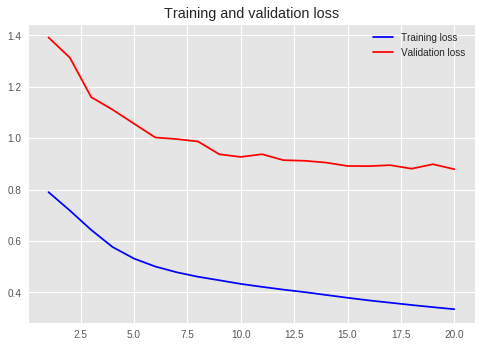

In [20]:
plot_history(history)

In [21]:
history.history.keys()

dict_keys(['val_loss', 'loss'])

In [0]:
# plot the model
plot_model(model, to_file='model.png', show_shapes=True)

In [23]:
!pip install pydot

In [0]:
import pydot

In [25]:
!apt-get install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
